# Binary black hole mergers in AGN disks -- Playing With Gas

### Chiara Mingarelli, cmingarelli@flatironinstitute.org

In [1]:
# RUN IN PYTHON 3.XX
from IPython.display import display, Math, Latex
import math
from math import sqrt, cos, sin, pi, log10
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, LinearLocator, NullFormatter, NullLocator, MultipleLocator
import matplotlib.ticker
import matplotlib.colors
from matplotlib.font_manager import FontProperties
from matplotlib import rc, text

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
# physical constants for natural units c = G = 1
c=2.99792458*(10**8)
G=6.67428*(10**(-11))
s_mass=G*(1.98892*10**(30))/(c**3)
solar_mass_gr = 1.989e33
secs_in_pc = 102927133.01 #about 1e8 s per pc

In [3]:
# Mass functions

def mu(m1,m2): return s_mass*(m1*m2)/(m1+m2) # reduced mass

def M(m1,m2):  return s_mass*(m1+m2) # total mass

def mchirp(m1,m2): return ((mu(m1,m2))**(3./5))*((M(m1,m2))**(2./5))  # chirp mass

def mchirp_q(q,Mtot): 
    """
    chirp mass in terms of q and M_tot. Answer in seconds.
    """
    ans = (q/(1+q)**2)**(3/5)*Mtot*s_mass
    return ans

def parsec2sec(d): return d*3.08568025e16/299792458

def sec2pc(sec): return 299792458*sec/3.08568025e16

# For GWs: strain, GW frequency and time to coalescence 
def generic_strain(q_mass_ratio, Mtot, dist, freq):
    strain = sqrt(32./5)*mchirp_q(q_mass_ratio,Mtot)**(5/3)*(pi*freq)**(2/3)/parsec2sec(dist*1e6)
    return strain

def generic_strain_wMc(chirp_mass, dist, freq):
    strain = sqrt(32./5)*(chirp_mass*s_mass)**(5/3)*(pi*freq)**(2/3)/parsec2sec(dist*1e6)
    return strain

def freq_gw(q, Mtot, tc):
    """
    GW frquency as a function of time to coalescence in years, total mass and mass ratio
    Result from integration of standard df/dt for GWs
    """
    ans = mchirp_q(q,Mtot)**(-5/8)/pi*(256/5*tc*31556926)**(-3/8)
    return ans

def freq_gw_wMc(chirp_mass, tc):
    """
    GW frquency as a function of time to coalescence in years and chirp mass (directly)
    Result from integration of standard df/dt for GWs
    """
    ans = (chirp_mass*s_mass)**(-5/8)/pi*(256/5*tc*31556926)**(-3/8)
    return ans

def time_to_c(q, Mtot, freq):
    """
    time to coalescence of a binary in seconds
    """
    ans = (pi*freq)**(-8/3)*mchirp_q(q,Mtot)**(-5/3)*5/256
    return ans

def time_to_c_wMc(chirp_mass, freq):
    """
    freq. in Hz, input chirp mass in solar masses, answer in years
    """
    ans = (pi*freq)**(-8/3)*(chirp_mass*s_mass)**(-5/3)*5/256
    return (ans/31556926)

def a_to_f(Mtot, fgw):
    # Kepler's 3rd law
    # answer in seconds
    frac = (Mtot*s_mass/(pi*fgw)**2)**(1./3)
    return frac

def fgw_to_a(Mtot, a_bh):
    """
    Kepler's 3rd law
    input BH mass in solar masses
    a in pc
    answer in seconds
    """
    ans = (Mtot*s_mass/parsec2sec(a_bh)**3)**(0.5)/pi
    return ans

In [4]:
# lisa starts at 0.5 AU
# ends at around 1e-2 AU

In [5]:
# Hardening and Dynamical Friction Timescales

In [6]:
# Black hole merger timescales from galaxy merger timescale; Binney and Tremaine 1987 
# "Galactic Dynamics"; also Sesana and Khan 2015

def t_hard(Mstar,q,gamma,Mtot):
    """
    Hardening timescale with stars, Eq. 7 Sesana & Khan 2015
    Answer in yrs
    """
    a_val = parsec2sec(r0_sol(Mstar, gamma))
    H = 15
    aStarGW = a_StarGW(Mstar,q,Mtot,gamma,H) #check units
    sigma_inf = sigmaVel(Mstar)*1000/c
    rinf_val = r_inf(Mstar,gamma,Mtot)
    rho_inf = rho_r(Mstar, gamma, rinf_val)
    ans = sigma_inf/(H*rho_inf*aStarGW)
    return ans/31536000

def t_gw(a, q, Mtot):
    # ans in yr
    # a in pc
    const = 5/256
    num = parsec2sec(a)**4
    deno = (Mtot*s_mass)**3 * q/(1+q)**2
    ans = const*num/deno
    return ans/31556926

def soundSpeed(Temp):
    """
    This is the sound speed, c_s, where c_s^2 = k_B*T/m_p
    Returns dimensionless quantity. To get physical units, multiply by c.
    """
    kbTemp_GR = 3.80526e-76*Temp # seconds, for 1K
    mProton = 4.14324e-63 #seconds
    ans = kbTemp_GR/mProton
    return sqrt(ans)
    
def Mdot_to_Sigma(a_bin, alpha, Temp, SigmaSurf, bin_Mass):
    """
    Parameters from Baruteau et al. 2011.
    SigmaSurf input in g/cm^2 (change to kg/m**2)
    input binary mass in solar masses (converts to seconds)
    input semimajor axis in pc (converts to seconds)
    answer is kg/s
    for solar masses, divide by 1.98892*1e30.
    """
    SigmaSurf = SigmaSurf*(1e-3)/(1e-2)**2
    num = 3*pi*alpha*(soundSpeed(Temp)*c)**2*SigmaSurf
    Omega = (bin_Mass*s_mass/(parsec2sec(a_bin)**3))**0.5 ## parsec to seconds, make sure all in seconds
    deno = Omega
    ans = num/deno #kg/s
    return ans

def a_bin(a_bhs,qmass):
    """
    Set a_bin to be the Hill radius, R_H ~ a(q/3)**1/3 for circular systems
    a_bhs is the semimajor axis of the stellar mass BHs, in pc
    answer in seconds
    """
    return parsec2sec(a_bhs)*(qmass/3)**(1/3)

def t_ACC(a_bhs,M1,M2,SigmaSurf,Temp, alpha):
    """
    temperature in Kelvin
    SigmaSurf input in g/cm^2
    BH masses in solar masses
    a_bhs in pc; start with 1e-3pc
    Answer in YEARS
    """
    SigmaSurf = SigmaSurf*(1/solar_mass_gr*s_mass)/(1e-2/c)**2
    a0 = sqrt(M(M1,M2)*s_mass/SigmaSurf)
    num = mu(M1,M2)*M(M1,M2)**0.25
    q=M2/M1
    deno = a_bin(a_bhs,q)*3*pi*alpha*soundSpeed(Temp)**2*SigmaSurf**0.75
    ans = num/deno
    return ans/31556926 #yrs
    
def t_baruteau(Temp, SigmaSurf, bin_Mass, SMBH_mass, a_SMBH, a_bin):
    """
    temperature in Kelvin
    SigmaSurf input in g/cm^2
    SMBH_mass in solar masses
    bin_mass in solar masses
    a_SMBH in pc
    a_bin in AU
    Answer in YEARS
    """
    const = 1/5.443310539518173e-10
    ans = const*(Temp/2000)**3*(SigmaSurf/100)**(-1)*(SMBH_mass/3e6)**(-0.5)*(bin_Mass/2)**(-2)*(a_SMBH/0.1)**(3/2)*(a_bin/50)
    return 900*ans
  
def t_sh(Mstar,q,gamma, Mtot, a_bin):
    # answer in yr
    sig = sigmaVel(Mstar) # M-sigma
    H = 15
    inf_rad = r_inf(Mstar,gamma,Mtot) # Influence radius
    rho_influence = rho_r(Mstar, gamma, inf_rad) #density profile at influence radius
    num = sig*1000/c
    deno = H*parsec2sec(a_bin)*rho_influence
    ans = num/deno
    return ans/31556926

def dy_fric_a(Mstar,M2, a):
    """
    Final eq from https://webhome.weizmann.ac.il/home/iair/astrocourse/tutorial8.pdf
    returns timescale in yr
    Mbh should be mass of secondary
    a in kpc
    """
    # assume log(Lambda) = 10
    vc = sqrt(2)*sigmaVel(Mstar)
    ans = 2.64e10*(a/2)**2*(vc/250)*(1e6/M2)
    return ans

def fmax(Mtot):
    const = 1/(np.pi*6**(3/2))
    ans = const/(Mtot*s_mass)
    return ans

def find_nearest(array,value):
    #returns index of matching value in array
    idx = (np.abs(array-value)).argmin()
    return idx 

def pc_to_AU(parParam):
    """
    change parsecs to AU
    input parsecs
    output in AU
    """
    return parParam*206265

def AU_to_pc(auParam): 
    """
    change AU measurement to parsecs
    """
    return auParam*4.8481e-6

def a_to_Om(Mtot, semi_a):
    # Kepler's 3rd law
    # answer in seconds
    semi_a = parsec2sec(semi_a) #parsecs to seconds
    frac = Mtot*s_mass/(semi_a)**3
    ans = frac**(1/2)
    return ans

def tempCheckwUnits(temp):
    mp = 938.23e6/c**2 #Mev/c^2
    kB = 8.617e-5 #eV/K
    ans = sqrt(kB*temp/mp)
    return ans

def fdot_gw(Mchirp,fgw):
    const = 96./5*pi**(8./3)
    num = (Mchirp*s_mass)**(5./3)*fgw**(11./3)
    ans = num*const
    return ans

def fdot_gw_mod(m1,m2,fgw):
    const = 96./5*pi**(8./3)
    num = (mchirp(m1,m2))**(5./3)*fgw**(11./3)
    ans = num*const
    return ans

def fdot_drag(m1,m2,fgw, temperature=1e5,rho_0=1e-6, Const=1):
    rho_0= rho_0*(1e-3)/(0.01)**3# cm -> m
    num = 2*rho_0*Const*3*(6.67428*(10**(-11)))**(5/3.)*((m1+m2)*2e30)**(2/3.)*fgw**(2./3)
    deno = (soundSpeed(temperature)*c)**2*2*pi**(1/3.)
    ans = num/deno
    return ans

In [7]:
gw_vec = []
drag_vec = []
xax = []
m1=0.5
m2=0.3
temperature = 1e5
Const=1
rho_0 = 1e-6


for qq in range (1,10000):
    qq=qq/10000
    xax.append(qq)
    gw_vec.append(fdot_gw_mod(m1,m2,qq))
    drag_vec.append(fdot_drag(m1,m2,qq,temperature,rho_0, Const))

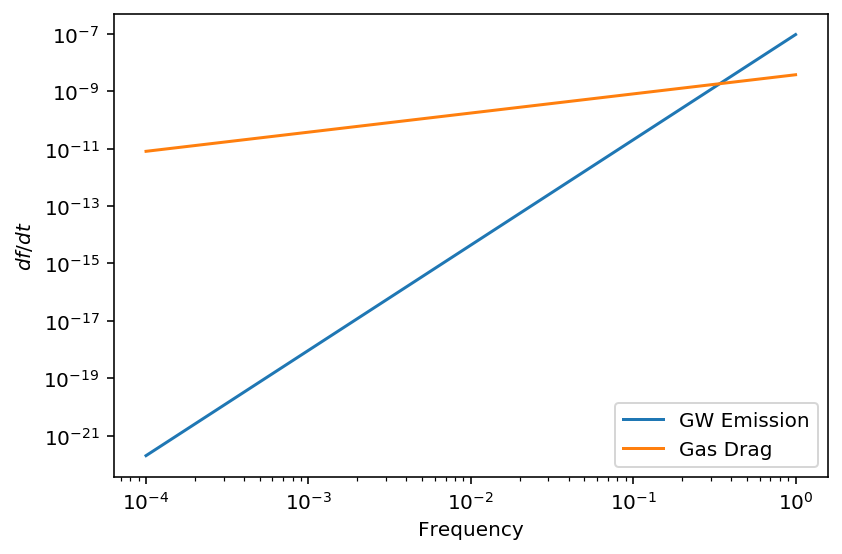

In [8]:
plt.loglog(xax, gw_vec, label = "GW Emission")
plt.loglog(xax, drag_vec, label="Gas Drag")
plt.xlabel("Frequency")
plt.ylabel(r"$df/dt$")
plt.legend(loc=4)
plt.tight_layout()
# plt.savefig("test_run_m1isOne.pdf")

In [13]:
fname = f"fdot_and_f_m1_{m1:.1f}_m2_{m2:.1f}.txt"
to_print = np.array([xax, gw_vec, drag_vec]).T
np.savetxt(fname, to_print)
# add header
header = """# These are calculated in BinaryResidenceTime_AGN_Disk-ChangeGas.ipynb
# using """+f"m1={m1:.1f}"+" and "+f"m2={m2:.1f}"+"""Msun
# GW_frequency roughly in the LISA range, from 10^-4 to 1 Hz
# the gw_fdot assumes pure GW-driven inspiral (Peters 1964)
# the drag_fdot assumes no-feedback and the drag is calculated using a
# temperature of """+f"{temperature:.0f} K"+" and density "+f"{rho_0} g cm^-3"+"""
# for the RSG envelope as representative
#
# GW_frequency	gw_fdot	drag_fdot
#
"""
# print(header)
with open(fname, "r+") as f:
    s = f.read()
    f.seek(0)
    f.write(header+s)


In [8]:
M1 = 99     # solar masses  
M2 = 1     # solar masses
Mtot = M1+M2
qratio = M2/M1
Temp = 10**5  # K this was 1e5.5... 
SigmaSurf = 10**(5.5) #g/cm^2, Figure 2 of Sirko & Goodman 2003
a_bhs = 1e-2 #pcs
alpha = 0.03
SMBH_mass = 1e7
a_SMBH = 0.1

In [112]:
# All in AU
t_bteau100 = [] # distance in AU, surface density /1000
t_bteau60 = []
t_gws100 = [] # distance in pc
t_gws60 = []
t_acc60 = [] 
t_acc100 = [] 
xaxis_t = []
t_all100 = []
t_all200 = []
# t_baruteau(Temp, SigmaSurf, bin_Mass, SMBH_mass, a_SMBH, a_bin) # functional form

for ii in range(1000*1000):
    ii = (ii+1)/1e5
    xaxis_t.append(ii)
    
    # Equal Mass 60 Msun binary
    t_bteau60.append(t_baruteau(Temp,SigmaSurf,60, SMBH_mass,1e-3, ii))
    t_gws60.append(t_gw(AU_to_pc(ii), 1, 60))   
    t_acc60.append(t_ACC(AU_to_pc(ii),30,30,SigmaSurf,Temp, alpha)) 
    
    # Unequal Mass 100:1 Msun binary
    t_bteau100.append(t_baruteau(Temp,SigmaSurf,100, SMBH_mass,1e-3, ii))
    t_gws100.append(t_gw(AU_to_pc(ii), 1/99, 100))   
    t_acc100.append(t_ACC(AU_to_pc(ii),99,1,SigmaSurf,Temp, alpha))  


    t_all200.append(min(t_baruteau(1e5,10**5.5,200,1e7,1e-3,ii), t_gw(AU_to_pc(ii), (1), 200), t_ACC(AU_to_pc(ii),100,100,SigmaSurf,Temp, alpha) ))
    t_all100.append(min(t_baruteau(1e5,10**5.5,100,1e7,1e-3,ii), t_gw(AU_to_pc(ii), (1/99), 100), t_ACC(AU_to_pc(ii),99,1,SigmaSurf,Temp, alpha) ))

In [105]:
# What are LISA Band Limits? 1e-4 to 1e-2 Hz
lisa_min = a_to_f(Mtot, 1e-4)/499.00478 #seconds converted to AU
lisa_max = a_to_f(Mtot, 1e-2)/499.00478 #seconds

ligo_min = a_to_f(Mtot, 10)/499.00478 #seconds converted to AU
ligo_max = a_to_f(Mtot, 80)/499.00478 #seconds to AU, and also up to isco freq = 76 Hz

et_min = a_to_f(Mtot, 1)/499.00478 #seconds converted to AU
et_max = a_to_f(Mtot, 1e3)/499.00478 #seconds to AU, and also up to isco freq = 76 Hz

In [106]:
import matplotlib.ticker as tck

/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/ticker.py:2516: UserWarning: AutoMinorLocator does not work with logarithmic scale
  warnings.warn('AutoMinorLocator does not work with logarithmic '
/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/ticker.py:2516: UserWarning: AutoMinorLocator does not work with logarithmic scale
  warnings.warn('AutoMinorLocator does not work with logarithmic '
/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/ticker.py:2516: UserWarning: AutoMinorLocator does not work with logarithmic scale
  warn

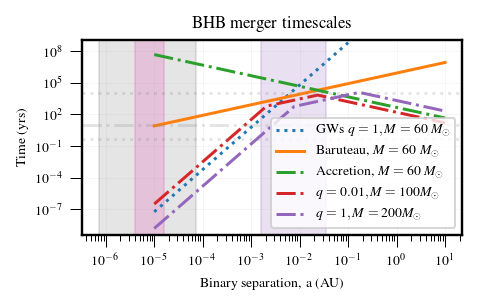

In [119]:
fig, ax1 = plt.subplots()
plt.title("BHB merger timescales")
#ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()

# Data
ax1.loglog(xaxis_t, t_gws60, label = "GWs $q=1, M=60~M_\odot$", linestyle = ":")
ax1.loglog(xaxis_t, t_bteau60, label = "Baruteau, $M=60~M_\odot$")
ax1.loglog(xaxis_t, t_acc60, label = "Accretion, $M=60~M_\odot$", linestyle="-.")

# Data
#ax1.loglog(xaxis_t, t_gws100, label = "GWs $q=1, M=60~M_\odot$", linestyle = ":")
#ax1.loglog(xaxis_t, t_bteau100, label = "Baruteau, $M=60~M_\odot$")
#ax1.loglog(xaxis_t, t_acc100, label = "Accretion, $M=60~M_\odot$", linestyle="-.")
ax1.loglog(xaxis_t, t_all100, label = "$q=0.01, M=100M_\odot$", linestyle="-.")
ax1.loglog(xaxis_t, t_all200, label = "$q=1, M=200M_\odot$", linestyle="-.")





# GW Detectors
ax1.axvspan(lisa_min, lisa_max, alpha=0.2,  color = 'C4' ) #LISA band
ax1.axvspan(et_min, et_max, alpha=0.2,  color = 'C7') #ET band
ax1.axvspan(ligo_min, ligo_max, alpha=0.3,  color = 'C6') #LIGO band

# Fine tuning
ax1.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
ax1.minorticks_on()
# Customize the major grid
#ax1.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
#ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

ax1.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(10))
#ax1.set_yscale('log')
ax1.grid(True, alpha=0.1, linewidth=0.5)
ax1.axhline(y=.5, alpha=0.2, linestyle = ":", color = 'grey')
ax1.axhline(y=10, alpha=0.2, linestyle = "-.", color = 'grey')
ax1.axhline(y=1e4, alpha=0.2, linestyle = ":", color = 'grey')


ax1.set_ylim((0.013157894736842105 / 31556926),1e9) # ymin is 1/f_isco
ax1.set_ylabel("Time (yrs)")
ax1.set_xlabel("Binary separation, a (AU)")
plt.legend(loc=4)
plt.tight_layout()
#plt.savefig("BHB_in_AGN_disk-25oct19-vary_qx2.pdf")